In [1]:
import numpy as np
from numba import jit
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12

In [2]:
def neighbourhood_points(X, x_centroid, look_distance ):
    eligible_X = []
    for x in X:
        distance_between = distance(x, x_centroid)
        #print('Evaluating: [%s vs %s] yield dist=%.2f' % (x, x_centroid, distance_between))
        if distance_between <= look_distance:
            eligible_X.append(x)
    eligible_X=np.asarray(eligible_X)
    return eligible_X

def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def gaussian_kernel(distance, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth)) ** 2)

In [3]:
@jit
def _shift_point(points,point, kernel_bandwidth, look_distance):
    
        new_x=[]
        neighbours = neighbourhood_points(points, point, look_distance)
        numerator = 0
        denominator = 0
        for neighbour in neighbours:
            lo_distance = distance(neighbour, point)
            weight = gaussian_kernel(lo_distance, kernel_bandwidth)
            numerator = numerator + (weight * neighbour)
            denominator = denominator + weight
        new_x = numerator / denominator
        point= new_x
        return point
    

@jit
def fit( points, kernel_bandwidth, look_distance,STOP_THRESHOLD):

        shift_points = points
        shifting = [True] * points.shape[0]

        while True:
            max_dist = 0
            for i in range(0, len(shift_points)):
                if not shifting[i]:
                    continue
                p_shift_init = shift_points[i].copy()
                shift_points[i] = _shift_point(points,shift_points[i], kernel_bandwidth,look_distance)
                dist = distance(shift_points[i], p_shift_init)
                max_dist = max(max_dist, dist)
                shifting[i] = dist > STOP_THRESHOLD         
            if(max_dist < STOP_THRESHOLD):
                break
        return shift_points     
    
@jit
def _cluster_points( points,CLUSTER_THRESHOLD):
        cluster_ids = []
        cluster_idx = 0
        cluster_centers = []
        z=points

        for i, point in enumerate(z):
            if(len(cluster_ids) == 0):
                cluster_ids.append(cluster_idx)
                cluster_centers.append(point)
                cluster_idx += 1
            else:
                for center in cluster_centers:
                    dist = distance(point, center)
                    if(dist < CLUSTER_THRESHOLD):
                        cluster_ids.append(cluster_centers.index(center))
                        break
                if(len(cluster_ids) < i + 1):
                    cluster_ids.append(cluster_idx)
                    cluster_centers.append(point)
                    cluster_idx += 1
        return cluster_ids

In [4]:
im = Image.open('/content/flight_pic.jpg')
image = np.array(im)
im_2 = cv2.resize(image, (100,60) , interpolation = cv2.INTER_AREA)
flat_image=np.reshape(im_2, [-1, 3])


In [5]:
shift_point= fit(flat_image, 5,50,100)

<ipython-input-3-89f05d0361d8>:18: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fit" failed type inference due to: Untyped global name 'distance': cannot determine Numba type of <class 'function'>

File "<ipython-input-3-89f05d0361d8>", line 31:
def fit( points, kernel_bandwidth, look_distance,STOP_THRESHOLD):
    <source elided>
                shift_points[i] = _shift_point(points,shift_points[i], kernel_bandwidth,look_distance)
                dist = distance(shift_points[i], p_shift_init)
                ^

  @jit
<ipython-input-3-89f05d0361d8>:18: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fit" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-3-89f05d0361d8>", line 24:
def fit( points, kernel_bandwidth, look_distance,STOP_THRESHOLD):
    <source elided>

        while True:
        ^

  @jit
/us

In [6]:
clusters2=  _cluster_points( shift_point.tolist(),CLUSTER_THRESHOLD=80)


<ipython-input-3-89f05d0361d8>:38: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cluster_points" failed type inference due to: Untyped global name 'distance': cannot determine Numba type of <class 'function'>

File "<ipython-input-3-89f05d0361d8>", line 52:
def _cluster_points( points,CLUSTER_THRESHOLD):
    <source elided>
                for center in cluster_centers:
                    dist = distance(point, center)
                    ^

  @jit
<ipython-input-3-89f05d0361d8>:38: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_cluster_points" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-3-89f05d0361d8>", line 45:
def _cluster_points( points,CLUSTER_THRESHOLD):
    <source elided>

        for i, point in enumerate(z):
        ^

  @jit
/usr/local/lib/python3.6/dist-packages/numba/object_mode_pass

(-0.5, 99.5, 59.5, -0.5)

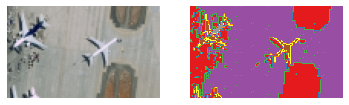

In [7]:

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(im_2)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(clusters2, [60,100]) ,cmap= 'Set1')
plt.axis('off')